In [30]:
import pandas as pd

df = pd.read_csv("dataset/housing.csv", encoding='utf-8-sig')

print("Shape:", df.shape)
print("\nFirst 3 rows:")
print(df.head(3))

print("\nData types:")
print(df.dtypes)

Shape: (20640, 10)

First 3 rows:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  

Data types:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


 Cleaned data: 20433 samples, 8 features

 Starting PSO optimization...
  Iteration   1: Best MSE = 0.594380
  Iteration  20: Best MSE = 0.378266
  Iteration  40: Best MSE = 0.369039
  Iteration  60: Best MSE = 0.364272
  Iteration  80: Best MSE = 0.364184
  Iteration 100: Best MSE = 0.364143

 Computing closed-form solution...
  Closed-form MSE: 0.363088

 Final Results:
  PSO MSE       : 0.364143
  Closed-form MSE: 0.363088


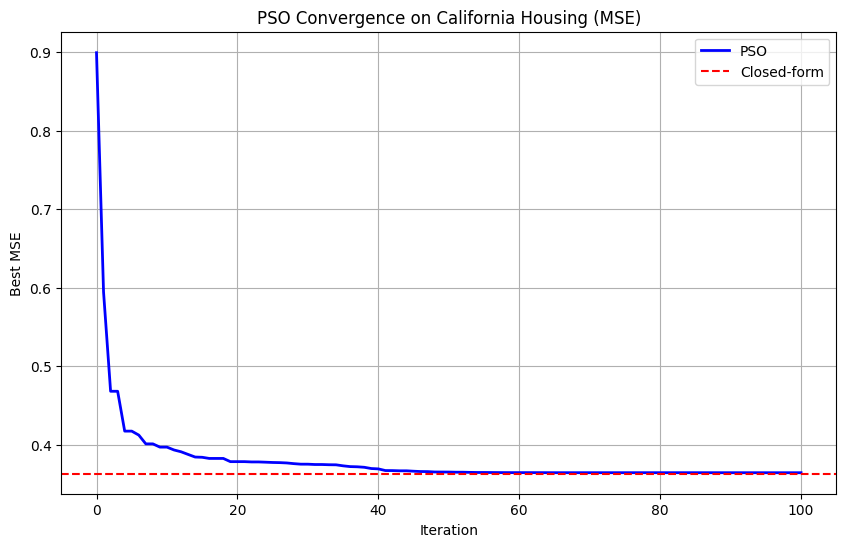

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1. Load data from local CSV file
df = pd.read_csv("dataset/housing.csv", encoding='utf-8-sig')

# Manually specify numeric features (exclude categorical 'ocean_proximity')
feature_columns = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income'
]
X = df[feature_columns].values
y = df['median_house_value'].values

# Remove any rows with NaN values
valid_indices = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X = X[valid_indices]
y = y[valid_indices]

print(f" Cleaned data: {X.shape[0]} samples, {X.shape[1]} features")

# Normalize features and target
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()


# 2. MSE cost function
def compute_mse(weights, X, y):
    w = weights[:-1]  # weights
    b = weights[-1]   # bias
    y_pred = X @ w + b
    return np.mean((y - y_pred) ** 2)


# 3. PSO implementation for linear regression
def pso_linear_regression(X, y, n_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
    n_dim = X.shape[1] + 1  # number of weights + bias
    np.random.seed(42)
    # np.random.seed(None)  
    positions = np.random.uniform(-1, 1, (n_particles, n_dim))  # Position
    velocities = np.random.uniform(-0.1, 0.1, (n_particles, n_dim))  # Velocity
    
    personal_best = positions.copy()  
    personal_best_fitness = np.array([compute_mse(p, X, y) for p in positions]) # Fitness
    
    global_best_idx = np.argmin(personal_best_fitness)
    global_best = personal_best[global_best_idx].copy()
    global_best_fitness = personal_best_fitness[global_best_idx]
    
    fitness_history = [global_best_fitness]
    
    print("\n Starting PSO optimization...")
    for t in range(max_iter):
        for i in range(n_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (personal_best[i] - positions[i]) +
                             c2 * r2 * (global_best - positions[i]))
            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], -1e6, 1e6)
            
            fitness = compute_mse(positions[i], X, y)
            if fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = fitness
                personal_best[i] = positions[i].copy()
                if fitness < global_best_fitness:
                    global_best_fitness = fitness
                    global_best = positions[i].copy()
        
        fitness_history.append(global_best_fitness)
        if (t + 1) % 20 == 0 or t == 0:
            print(f"  Iteration {t+1:3d}: Best MSE = {global_best_fitness:.6f}")
    
    return global_best, fitness_history


# 4. Run PSO
best_weights_pso, history = pso_linear_regression(X, y, n_particles=30, max_iter=100)


# 5. Compare with closed-form solution
print("\n Computing closed-form solution...")
X_with_bias = np.hstack([X, np.ones((X.shape[0], 1))])
theta_closed = np.linalg.pinv(X_with_bias) @ y
mse_closed = compute_mse(theta_closed, X, y)
print(f"  Closed-form MSE: {mse_closed:.6f}")


# 6. Print final results
print(f"\n Final Results:")
print(f"  PSO MSE       : {history[-1]:.6f}")
print(f"  Closed-form MSE: {mse_closed:.6f}")


# 7. Plot convergence curve
plt.figure(figsize=(10, 6))
plt.plot(history, 'b-', linewidth=2, label='PSO')
plt.axhline(y=mse_closed, color='r', linestyle='--', label='Closed-form')
plt.title("PSO Convergence on California Housing (MSE)")
plt.xlabel("Iteration")
plt.ylabel("Best MSE")
plt.legend()
plt.grid(True)
plt.show()